In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

The following initial values are provided in the book:
1. The abundance of the decaying particle, $Y_i = 3.2\times 10^{-5}$
2. The ratio of the energy density between the decaying particle and the radiations, $\rho_\psi/\rho_r = 10$
3. The product of Hubble parameter and the decaying particle's lifetime, $H_i\tau = 100$
4. The equation relating the effective degree of freedom of the radiation $g_{*}$, the Planck mass $m_{pl}$, and the lifetime $\tau$ and mass $m$ of the decaying particle, $\tau/{M_{pl}} = 10^{12}/(m^2g_*^{1/2})$.

Together with the following set of differential equations to solve:
\begin{align}
S^{1/3}\frac{dS}{dt} &= \left(\frac{2\pi^2}{45}g_{*}\right)^{1/3}R^4\frac{\rho_{\psi}}{\tau}\\
\frac{d\rho_{\psi}}{dt} + 3H\rho_{\psi} &= \frac{\rho_{\psi}}{\tau}\\
\left(\frac{1}{R}\frac{dR}{dt}\right)^2 &= H^2 = \frac{8\pi}{3m_{pl}^2}(\rho_{\psi} + \rho_R)
\end{align}

where
\begin{align*}
\rho_R = \frac{pi^2}{30}g_{*}T^4 ~~~~~~~~~; S = \frac{2\pi^2}{45} g_{*}T^3R^3
\end{align*}

For some reason, the current code reproduces an exact replica of the plot only when setting $H_i\tau = 300$. This might hint that there are some mistakes in the code, but hopefully they are not very fundamental.

In [5]:
#Arbitrary values that we need to specify for our numerical calculation
m = 10000
g = 100
R0 = 100
Mpl = 1.22e19 * 6.6e-25

#Initial values provided by the book
Abundan = 3.2e-5
rho_rat = 10
Hubblet = 300
tauperM = 1e12/((m**2) * np.sqrt(g))

The radiation entropy is related with the temperature, via $S\sim g_{*}T^3$. For $g_{*} = g_{*}(T)$, this entropy-temperature relation become non-trivial and one might prefer knowing the temperature evolution first and deducing the entropy evolution afterwards. Thus, it is typically more convenient the differential equation for entropy into a differential equation for temperature. Fortunately, for this simple case, $g_{*}$ is constant, so the equation straightforwardly becomes
\begin{align*}
\left(\frac{2\pi^2}{45}g_{*} T^3R^3\right)^{1/3}\frac{d}{dt}\left(\frac{2\pi^2}{45}g_{*} T^3R^3\right) &= \left(\frac{2\pi^2}{45}g_{*}\right)^{1/3}R^4\frac{\rho_{\psi}}{\tau}\\
\frac{2\pi^2}{45}g_{*}TR\frac{d}{dt}\left(T^3R^3\right) &= R^4\frac{\rho_{\psi}}{\tau}\\
\frac{2\pi^2}{15}g_{*}TR\left(T^2R^3\frac{dT}{dt} + T^3R^2\frac{dR}{dt}\right) &= R^4\frac{\rho_{\psi}}{\tau}\\
\frac{2\pi^2}{15}g_{*}T^3\left(\frac{dT}{dt} + \frac{T}{R}\frac{dR}{dt}\right) &= \frac{\rho_{\psi}}{\tau}\\
\frac{dT}{dt} + HT &= \frac{15}{2\pi^2g_{*}T^3}\frac{\rho_{\psi}}{\tau}\\
\frac{dT}{dt} &= \frac{15}{2\pi^2g_{*}T^3}\frac{\rho_{\psi}}{\tau} - HT\\
\end{align*}

This is also the reason why in above lines, we specify some arbitrary values of $m, g_{*}, R_0$ and $m_{pl}$.

In [6]:
#Computing more initial values relevant to our current system of differential equations
tau    = tauperM * Mpl
H0     = Hubblet / tau

rho_n0 = ((H0 * Mpl)**2) * 3 / (8 * np.pi * (rho_rat + 1))
rho_0  = rho_n0 / rho_rat
T0     = (30 * rho_0 / (g * (np.pi**2)))**(1/4)

Sn0    = rho_n0 * (R0**3) / (m * Abundan)
S0     = (2 * (np.pi**2) * g / 45) * (T0**3) * (R0**3)

print(tau, H0, rho_n0, rho_0, T0, Sn0, S0)

0.008052 37257.824143070044 0.0009766326053366307 9.766326053366307e-05 0.04150860921350848 3051.976891676971 3137.124639415117


Our final set of equations are
\begin{align}
\frac{dT}{dt} &= \frac{15}{2\pi^2g_{*}T^3}\frac{\rho_{\psi}}{\tau} - H(\rho_{\psi}, T)T\\
\frac{d\rho_{\psi}}{dt} &= \frac{\rho_{\psi}}{\tau} - 3H(\rho_{\psi}, T)\rho_{\psi}\\
\frac{dR}{dt} &= H((\rho_{\psi}, T))R
\end{align}

Accompanied by the following relevant equations
\begin{align}
\rho_R &= \frac{\pi^2}{30}g_{*}T^4\\
S &= \frac{2\pi^2}{45} g_{*}T^3R^3\\
H &= \frac{1}{m_{pl}}\sqrt{\frac{8\pi}{3}(\rho_{\psi} + \rho_R)}
\end{align}

In [7]:
def rho(T):
    return ((np.pi**2) / 30) * g * (T**4)

def S(T, R):
    return (2 * (np.pi**2) * g / 45) * (T**3) * (R**3)

def Hubble(rho_n, T):
    return (1 / Mpl) * np.sqrt((8 * np.pi / 3) * (rho_n + rho(T)))

def funcT(rho_n, T, R):
    return (15/(2 * (np.pi**2) * (T**3) * g)) * (rho_n / tau) - Hubble(rho_n, T) * T

def funcr(rho_n, T, R):
    return -(rho_n / tau) - 3 * Hubble(rho_n, T) * rho_n

def funcR(rho_n, T, R):
    return R * Hubble(rho_n, T)

In [9]:
def func(t, y):
    rho_n, T, R = y[0], y[1], y[2]
    # print(rho_n, T, R)
    # print(Hubble(rho_n, T)*tau)
    return [funcr(rho_n, T, R), funcT(rho_n, T, R), funcR(rho_n, T, R)]

evals = np.logspace(-6, np.log10(tau * 1e3 - 1), 1000)

sol = solve_ivp(fun=func, t_span=[1e-6, tau * 1e3], y0=[rho_n0, T0, R0], t_eval=evals, method='BDF', max_step = tau)

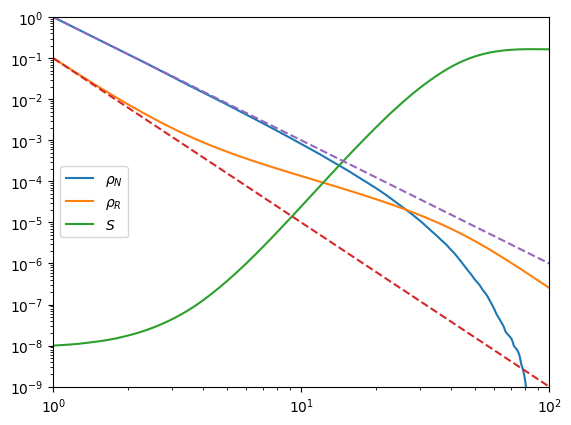

In [10]:
plt.loglog(sol.y[2]/sol.y[2][0], sol.y[0] / sol.y[0][0], label=r'$\rho_N$')
plt.loglog(sol.y[2]/sol.y[2][0], [rho(sol.y[1][i]) / sol.y[0][0] for i in range(len(sol.y[1]))], label=r'$\rho_R$')
plt.loglog(sol.y[2]/sol.y[2][0], [((S(sol.y[1][i], sol.y[2][i])/S0)**4)/1e8 for i in range(len(sol.y[1]))], label=r'$S$')
plt.loglog(sol.y[2]/sol.y[2][0], ((R0/sol.y[2])**4)/10, linestyle='dashed')
plt.loglog(sol.y[2]/sol.y[2][0], ((R0/sol.y[2])**3), linestyle='dashed')
# plt.loglog(sol.y[2]/R0, sol.y[2] * sol.y[1] / (T0*R0))
plt.ylim(1e-9, 1e0)
plt.xlim(1e0, 1e2)
plt.legend()
plt.show()